In [123]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [124]:
import numpy as np
import scipy
import scipy.linalg
import scipy.stats
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

In [125]:
def plot_3d_function(f, a = 10, k = 100):
    x = np.linspace(-a, a, k)
    y = x.copy()
    xy = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
    z = f(xy)
    fig = go.Figure(data=[go.Surface(x = x,  y= y, z=z.reshape((x.shape[0], -1)))])
    fig.update_layout(title = f.__name__, margin=dict(l=65, r=50, b=65, t=90))
    fig.show()

# Funkcje celu

In [126]:
def sphere_function(X):
    return np.sum(X**2, axis=1)

In [127]:
plot_3d_function(sphere_function)

In [128]:
def ellipsoid_function(X, a=2):
    n = X.shape[-1]
    return np.sum((a**(np.arange(n)/(n-1)))*X**2, axis=1)

In [129]:
def rastrigin_function(X):
    return 10.0 * X.shape[1] + np.sum(X**2, axis=1) - 10.0 * np.sum(np.cos(2 * np.pi * X), axis=1)

In [130]:
def schwefel_function(X):
    return 418.9829 * X.shape[1] - np.sum(X * np.sin(np.sqrt(np.abs(X))), axis=1)

In [131]:
def griewank_function(X):
    return 1 + np.sum(X**2 / 4000, axis=1) - np.prod(np.cos(X / np.sqrt(np.linspace(1, X.shape[1], X.shape[1]))), axis=1)

In [132]:
def cigar_function(X, a = 3):
    if len(X.shape) == 1:
        X = X[np.newaxis,:]
    x1 = X[:,0]**2
    x2 = np.sum(a*X[:,1:]**2, axis = 1)
    return x1+x2

In [133]:
def discus_function(X, a = 3):
    if len(X.shape) == 1:
        X = X[np.newaxis,:]
    x1 = a*X[:,0]**2
    x2 = np.sum(X[:,1:]**2, axis = 1)
    return x1+x2

In [134]:
def cigar_discus_function(X, a = 2):
    if len(X.shape) == 1:
        X = X[np.newaxis,:]
    x1 = a*X[:,0]**2
    x2 = np.sum((a**0.5)*X[:,1:-1]**2, axis = 1)
    x3 = X[:,-1]**2
    return x1+x2+x3

In [135]:
def parab_ridge_function(X):
    if len(X.shape) == 1:
        X = X[np.newaxis,:]
    x1 = - X[:,0]
    x2 = 100*np.sum(X[:,1:]**2, axis = 1)
    return x1+x2

In [136]:
def two_axes_function(X, a = 5):
    if len(X.shape) == 1:
        X = X[np.newaxis,:]
    n = X.shape[-1]
    k = n//2
    x1 = np.sum(a*X[:,:k]**2, axis = 1)
    x2 = np.sum(X[:,k:]**2, axis = 1)
    return x1+x2

# Implementacja CMA-ES

In [137]:
class CMA_ES2:
    def __init__(self, x0, sigma, maxfevals = 10000, popsize = None, weights = None):
        N = x0.shape[0]
        self.dimension = N
        self.chiN = N**0.5 * (1 - 1. / (4 * N) + 1. / (21 * N**2))
        self.lam = 4 + int(3 * np.log(N)) if not popsize else popsize
        print(f"Popsize: {self.lam}")
        self.mu = int(self.lam / 2)
        
        if weights:
            self.weights = weights
        else:
            self.weights = np.array([np.log(self.lam / 2 + 0.5) - np.log(i + 1) if i < self.mu else 0
                        for i in range(self.lam)])
            self.weights /= np.sum(self.weights)
        self.mueff = np.sum(self.weights)**2 / np.sum(self.weights**2)
        
        self.cc = (4 + self.mueff/N) / (N+4 + 2 * self.mueff/N)
        self.cs = (self.mueff + 2) / (N + self.mueff + 5)
        self.c1 = 2 / ((N + 1.3)**2 + self.mueff) 
        self.cmu = min([1 - self.c1, 2 * (self.mueff - 2 + 1/self.mueff) / ((N + 2)**2 + self.mueff)])
        self.damps = 2 * self.mueff/self.lam + 0.3 + self.cs

        self.xmean = x0[:]
        self.sigma = sigma
        self.pc = np.zeros(N) 
        self.ps =np.zeros(N) 
        self.lazy_gap_evals = 0.5 * N * self.lam * (self.c1 + self.cmu)**-1 / N**2
        self.maxfevals = maxfevals
        self.C = np.identity(N)
        self.counteval = 0 
        self.fitvals = []   
        self.best = (x0, None)
        self.condition_number = 1
        self.eigen_values = np.ones(N)
        self.eigen_vectors = np.identity(N)
        self.updated_eval = 0
        self.inv_sqrt = np.identity(N)

    def _update_eigensystem(self, current_eval, lazy_gap_evals):
#         if current_eval <= self.updated_eval + lazy_gap_evals:
#             return self
        self.eigen_values, self.eigen_vectors = np.linalg.eig(self.C)
        self.inv_sqrt = self.eigen_vectors @ np.diag(self.eigen_values**-0.5) @ self.eigen_vectors.T
        self.condition_number = self.eigen_values.max() / self.eigen_values.min()
         
    def sample(self):
        """Wylosuj próbkę nowych osobników"""
        # TODO
        y = self.xmean + self.sigma * np.dot(np.random.randn(self.lam, self.dimension), 
                                                  np.linalg.cholesky(self.C).T)
        return y
    
    def update(self, x, fitvals):
        """Zaktualizuj wartości uzyskanych parametrów"""
        self.counteval += fitvals.shape[0] # Zwiększamy licznik wykonań
        N = self.xmean.shape[0]
        x_old = self.xmean.copy()
        
        # Posortuj osobniki po wartości funkcji celu
        # TODD
        I = np.argsort(fitvals)
        x = x[I, :]
        
        #TODO Wartości funkcji celu dla posortowanych użytkowników
        self.fitvals = fitvals[I]
        self.best = (x[0], self.fitvals[0])        
        self.xmean = (self.weights @ x).ravel()
        
#         self.xmean = x_old  + (self.weights @ (x - x_old)).ravel()
        

        # Wektor przesunięcia średniej
        y = (x - x_old)/self.sigma
#         print(self.inv_sqrt, self.inv_sqrt.shape, y, y.shape)
#         W sumie nie używane
        z = (self.inv_sqrt @ y.T).T
        
        # Aktualizacja ścieżki ewolucji dla sigmy

        self.ps = (1-self.cs) * self.ps + np.sqrt(self.cs*(2-self.cs)*self.mueff) * (self.inv_sqrt @ \
                (self.xmean - x_old) / self.sigma)
 
        # Aktualizacja ścieżki ewolucji dla macierzy kowariancji
        self.pc = (1-self.cc) * self.pc + np.sqrt(self.cc*(2-self.cc)*self.mueff) * (self.xmean - x_old)/self.sigma
        
        #Aktualizacja macierzy kowariancji
        C_mu = np.sum(np.array([w * np.outer(yi, yi) for w, yi in zip(self.weights, y)]), axis=0)
        
        self.C = (1-self.c1-self.cmu*np.sum(self.weights))*self.C +\
                 self.c1 * self.pc.reshape(-1,1) @ self.pc.reshape(1,-1) +\
                 self.cmu * C_mu

        self.C = (self.C + self.C.T)/2.0 # Upewniamy się, że macierz jest symetryczna
        
        # Aktualizacja rozmiaru kroku
        
        self.sigma = self.sigma * np.exp(self.cmu/self.damps * (np.linalg.norm(self.ps) / self.chiN - 1))
        
#         print("\nxmean:", self.xmean, "\nC:", self.C, "\nsigma:", self.sigma)
#         ????????
        self._update_eigensystem(1.0, 0.0) 
    
    def terminate(self):
        """Zakończ algorytm"""
        if self.counteval <= 0:
            return False
        if self.counteval >= self.maxfevals:
            return True
        if self.condition_number > 1e13:
            return True
        if self.sigma * np.max(self.eigen_values)**0.5 < 1e-13:
            return True
        return False

In [138]:
class CMA_ES:
    def __init__(self, x0, sigma, maxfevals = 10000, popsize = None, weights = None):
        N = x0.shape[0]
        self.dimension = N
        self.chiN = N**0.5 * (1 - 1. / (4 * N) + 1. / (21 * N**2))
        self.lam = 4 + int(3 * np.log(N)) if not popsize else popsize
        print(f"Popsize: {self.lam}")
        self.mu = int(self.lam / 2)
        
        if weights:
            self.weights = weights
        else:
            self.weights = np.array([np.log(self.lam / 2 + 0.5) - np.log(i + 1) if i < self.mu else 0
                        for i in range(self.lam)])
            self.weights /= np.sum(self.weights)
        self.mueff = np.sum(self.weights)**2 / np.sum(self.weights**2)
        
        self.cc = (4 + self.mueff/N) / (N+4 + 2 * self.mueff/N)
        self.cs = (self.mueff + 2) / (N + self.mueff + 5)
        self.c1 = 2 / ((N + 1.3)**2 + self.mueff) 
        self.cmu = min([1 - self.c1, 2 * (self.mueff - 2 + 1/self.mueff) / ((N + 2)**2 + self.mueff)])
        self.damps = 2 * self.mueff/self.lam + 0.3 + self.cs

        self.xmean = x0[:]
        self.sigma = sigma
        self.pc = np.zeros(N) 
        self.ps =np.zeros(N) 
        self.lazy_gap_evals = 0.5 * N * self.lam * (self.c1 + self.cmu)**-1 / N**2
        self.maxfevals = maxfevals
        self.C = np.identity(N)
        self.counteval = 0 
        self.fitvals = np.array([])  
        self.best = (x0, None)
        self.condition_number = 1
        self.eigen_values = np.ones(N)
        self.eigen_vectors = np.identity(N)
        self.updated_eval = 0
        self.inv_sqrt = np.identity(N)

    def _update_eigensystem(self, current_eval, lazy_gap_evals):
        if current_eval <= self.updated_eval + lazy_gap_evals:
            return self
        self.eigen_values, self.eigen_vectors = np.linalg.eig(self.C)
        self.inv_sqrt = self.eigen_vectors @ np.diag(self.eigen_values**-0.5) @ self.eigen_vectors.T
        self.condition_number = self.eigen_values.max() / self.eigen_values.min()
         
    def sample(self):
        """Wylosuj próbkę nowych osobników"""
        y = self.xmean + self.sigma * np.random.multivariate_normal(np.zeros(self.dimension),
                                                                    self.C,self.lam)
        return y
    
    def update(self, x, fitvals):
        """Zaktualizuj wartości uzyskanych parametrów"""
        self.counteval += fitvals.shape[0] # Zwiększamy licznik wykonań
        N = self.xmean.shape[0]
        x_old = self.xmean.copy()
        
        # Posortuj osobniki po wartości funkcji celu
        # TODD
        I = np.argsort(fitvals)
        x = x[I, :]
        self.fitvals = fitvals[I]
        self.best = (x[0], self.fitvals[0])
        self.xmean = (self.weights @ x).ravel()
        y = self.xmean - x_old
        #z = # TODO
        
        # Aktualizacja ścieżki ewolucji dla sigmy
        self.ps = (1-self.cs)*self.ps + np.sqrt(self.cs*(2-self.cs)*self.mueff) * (self.inv_sqrt @ y / self.sigma )
        
        # Aktualizacja ścieżki ewolucji dla macierzy kowariancji
        self.pc = (1-self.cc)*self.pc + np.sqrt(self.cc*(2-self.cc)*self.mueff) * y / self.sigma
        
        #Aktualizacja macierzy kowariancji\
        tmp = np.sum(np.array([w * np.outer(yi, yi) for w, yi in zip(self.weights, y)]), axis=0)
        self.C = (1 - self.c1 - self.cmu*np.sum(self.weights)) * self.C + \
        self.c1 * self.pc.reshape(-1,1) @ self.pc.reshape(1,-1) + self.cmu * tmp

        self.C = (self.C + self.C.T)/2.0 # Upewniamy się, że macierz jest symetryczna
        
        # Aktualizacja rozmiaru kroku
        
        self.sigma = self.sigma * np.exp(self.cmu/self.damps * (np.linalg.norm(self.ps) / self.chiN - 1))
        self._update_eigensystem(self.counteval,self.lazy_gap_evals)
        
    def terminate(self):
        """Zakończ algorytm"""
        if self.counteval <= 0:
            return False
        if self.counteval >= self.maxfevals:
            return True
        if self.condition_number > 1e13:
            return True
        if self.sigma * np.max(self.eigen_values)**0.5 < 1e-13:
            return True
        return False

In [139]:
def add_ellipse(ax,sigma,mean,color):
    a = sigma[0][0]
    b = sigma[0][1]
    c = sigma[1][1]
    lambda_1 = (a+c)/2 + np.sqrt(((a-c)/2)**2 + b**2)
    lambda_2 = (a+c)/2 - np.sqrt(((a-c)/2)**2 + b**2)
    ellipse = Ellipse((0, 0),edgecolor=color,facecolor='none', width=np.sqrt(5.991*lambda_1) * 2, height=np.sqrt(5.991*lambda_2) * 2)
    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .translate(mean[0], mean[1])
    ellipse.set_transform(transf + ax.transData)
    ax.add_patch(ellipse)
    return

In [140]:
def optimize(func, x0, sigma, maxfevals = 1000, popsize = None, weights = None, generations_plot = False):
    cma_es = CMA_ES(x0, sigma, maxfevals, popsize, weights)
    res = []
    cntr = -1
    if generations_plot:
        fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3,figsize=(15,10))
        l = [ax1,ax2,ax3,ax4,ax5,ax6]
    while not cma_es.terminate():
        cntr+=1
        x = cma_es.sample()
        f_eval = func(x)
        if cntr < 6 and generations_plot:
            I = np.argsort(f_eval)
            x = x[I]
            f_eval = f_eval[I]
            x_good = x[:cma_es.mu][:,0]
            y_good = x[:cma_es.mu][:,1]
            x_bad = x[cma_es.mu:][:,0]
            y_bad = x[cma_es.mu:][:,1]
            old_C = cma_es.C
            old_mean = cma_es.xmean
            cma_es.update(x, f_eval)
            res.append(cma_es.best)
            new_C = cma_es.C
            new_mean = cma_es.xmean
            # plot
            x_min, x_max = min(x[:][:,0]), max(x[:][:,0])
            y_min, y_max = min(x[:][:,1]), max(x[:][:,1])
            X, Y = np.meshgrid(np.linspace(x_min*0.95,x_max*1.05,20),np.linspace(y_min*0.95,y_max*1.05,40))
            Z = - func(np.vstack([X.ravel(), Y.ravel()]).T).reshape(X.shape[0], X.shape[1])
            l[cntr%6].contour(X, Y, Z, 50)
            l[cntr%6].set_title('Generation {}'.format(cntr))
            l[cntr%6].scatter(x_good, y_good)
            l[cntr%6].scatter(x_bad, y_bad)
            add_ellipse(l[cntr%6], old_C, old_mean, 'tab:orange')
            add_ellipse(l[cntr%6], new_C, new_mean, 'b')
        else:
            cma_es.update(x, f_eval)
            res.append(cma_es.best)
        if cntr % 100 == 0:
            print(f"Iteration {cntr:5d}: {res[-1][1]}")
    if generations_plot:
        for ax in fig.get_axes():
            ax.label_outer()
    return res

In [141]:
def optimize_and_plot(f, sigma = 1, d = 10, popsize = 10, generations_plot = False):
    x0 = np.repeat(100.0, d)
    res = optimize(f, x0, sigma, popsize=popsize,generations_plot = generations_plot)
    print(f"Best: {res[-1][0]}, value: {res[-1][1]}")
    y = np.array([nd for st, nd in res])
    fig = px.line(x = np.arange(y.shape[0]) + 1, y = y)
    fig.show()

# Ewaluacja CMA-ES

### Zadanie 1

Popsize: 10
Iteration     0: 19498.015410365104
Best: [-1.68880010e-05 -1.92760441e-04], value: 3.7441792284866734e-08


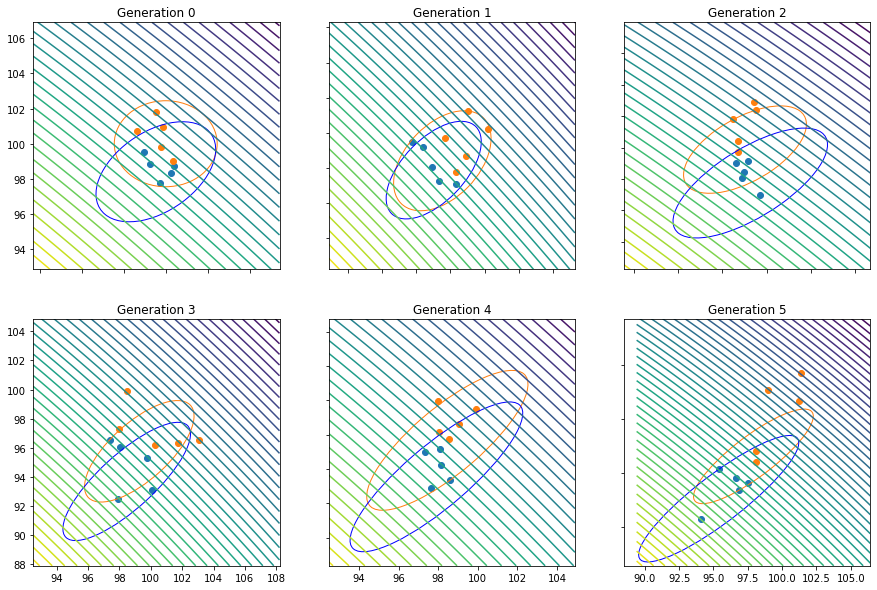

In [142]:
optimize_and_plot(sphere_function, d = 2, generations_plot = True)

Popsize: 10
Iteration     0: 29690.47209692606
Best: [-1.91952836e-06 -1.78392648e-06], value: 1.0049376465259525e-11


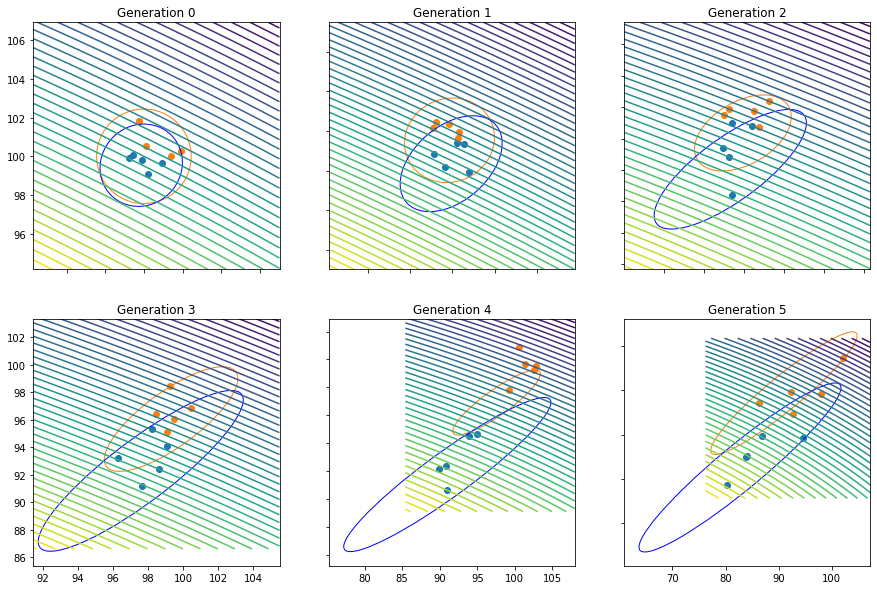

In [143]:
optimize_and_plot(ellipsoid_function, d = 2, generations_plot = True)

Popsize: 10
Iteration     0: 39117.33682436655
Best: [3.95834257e-05 5.86070908e-04], value: 1.0320041742274096e-06


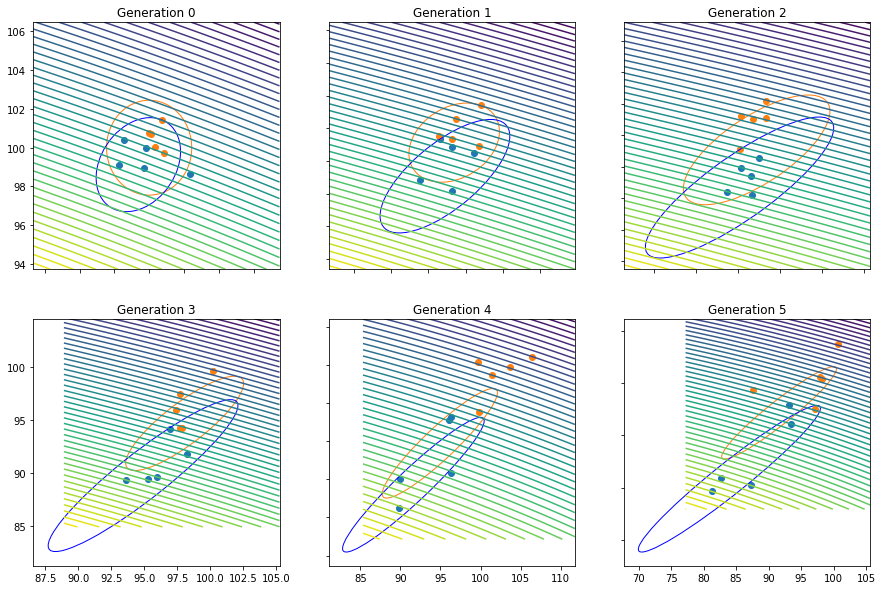

In [144]:
optimize_and_plot(cigar_function, d = 2, generations_plot = True)

Popsize: 10
Iteration     0: 19629.33733262137
Best: [0.00011972 0.00017952], value: 9.237565894437694e-06


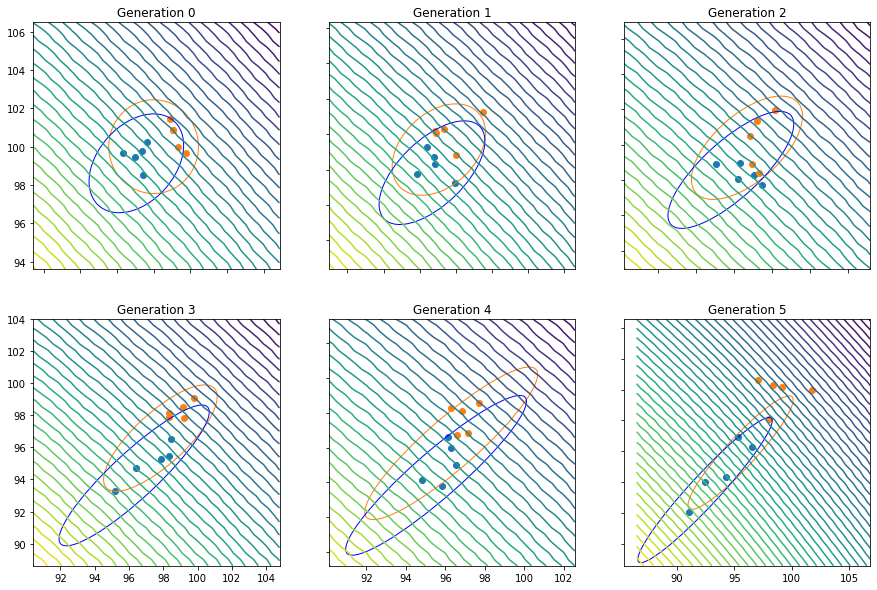

In [145]:
optimize_and_plot(rastrigin_function, d = 2, generations_plot = True)

In [146]:
optimize_and_plot(sphere_function, sigma = 200)

Popsize: 10
Iteration     0: 273355.4907635579
Best: [34294156.30396098 34294874.1746459  34294597.14416704 34294040.49678443
 34294865.66606142 34294496.16672018 34294135.12358802 34294079.86440662
 34294125.25938205 34295482.40917056], value: 1.1761117195118612e+16


In [147]:
optimize_and_plot(sphere_function)

Popsize: 10
Iteration     0: 98548.78073190514
Best: [ 8.97817229  1.59740593  8.42898465 -1.98483296  8.28861774 -3.21122373
  2.31435754  2.83170709 -3.95566108 -4.73383278], value: 288.59101249051355


In [148]:
optimize_and_plot(ellipsoid_function)

Popsize: 10
Iteration     0: 143484.40188769446
Best: [ 1.84158284  2.44483376  0.02085204 -4.66078809 -1.8621307  -1.12868195
 -3.18230624  3.9626072  -3.46706619  4.10190617], value: 142.71515301488265


In [149]:
optimize_and_plot(griewank_function)

Popsize: 10
Iteration     0: 25.873321428603973
Best: [-8.88315997 -1.14322104 -5.51460881 -7.31113112 -1.55477665 -2.18350319
 -7.71506546 -0.16498719 -3.79260774 -1.25221643], value: 0.9943866765944054


In [150]:
optimize_and_plot(rastrigin_function)

Popsize: 10
Iteration     0: 98842.51714872483
Best: [-6.96092843 -1.42555521  2.14851708 -5.13443636 -2.37606089  1.56660308
  1.5492584   0.06720898 -1.70418813  0.91923566], value: 193.10970425394473


### Zadanie 2

In [151]:
def es(objective_function, chromosome_length, population_size, number_of_iterations, number_of_offspring, number_of_parents, sigma, tau, tau_0, log_frequency=1):

    best_solution = np.empty((1, chromosome_length))
    best_solution_objective_value = -100000

    log_objective_values = np.empty((number_of_iterations, 4))
    log_best_solutions = np.empty((number_of_iterations, chromosome_length))
    log_best_sigmas = np.empty((number_of_iterations, chromosome_length))

    # generating an initial population
    current_population_solutions = 360.0 * np.random.rand(population_size, chromosome_length)
    current_population_sigmas = sigma * np.ones((population_size, chromosome_length))

    # evaluating the objective function on the current population
    current_population_objective_values = np.array([objective_function(c) for c in current_population_solutions])

    for t in range(number_of_iterations):

        # selecting the parent indices by the roulette wheel method
        fitness_values = current_population_objective_values - current_population_objective_values.min()
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = 1.0 / population_size * np.ones(population_size)
        parent_indices = np.random.choice(population_size, (number_of_offspring, number_of_parents), True, fitness_values).astype(np.int64)

        # creating the children population by Global Intermediere Recombination
        children_population_solutions = np.zeros((number_of_offspring, chromosome_length))
        children_population_sigmas = np.zeros((number_of_offspring, chromosome_length))
        for i in range(number_of_offspring):
            children_population_solutions[i, :] = current_population_solutions[parent_indices[i, :], :].mean(axis=0)
            children_population_sigmas[i, :] = current_population_sigmas[parent_indices[i, :], :].mean(axis=0)

        # mutating the children population by adding random gaussian noise
        children_population_sigmas = children_population_sigmas * np.exp(tau * np.random.randn(number_of_offspring, chromosome_length) + tau_0 * np.random.randn(number_of_offspring, 1))
        children_population_solutions = children_population_solutions + children_population_sigmas * np.random.randn(number_of_offspring, chromosome_length)

        # evaluating the objective function on the children population
        children_population_objective_values = np.array([objective_function(c) for c in children_population_solutions])
        # replacing the current population by (Mu + Lambda) Replacement
        current_population_objective_values = np.hstack([current_population_objective_values, children_population_objective_values])
        current_population_solutions = np.vstack([current_population_solutions, children_population_solutions])
        current_population_sigmas = np.vstack([current_population_sigmas, children_population_sigmas])

        I = np.argsort(current_population_objective_values)[::-1]
        current_population_solutions = current_population_solutions[I[:population_size], :]
        current_population_sigmas = current_population_sigmas[I[:population_size], :]
        current_population_objective_values = current_population_objective_values[I[:population_size]]

        # recording some statistics
        if best_solution_objective_value < current_population_objective_values[0]:
            best_solution = current_population_solutions[0, :]
            best_solution_objective_value = current_population_objective_values[0]
        log_objective_values[t, :] = [current_population_objective_values.min(), current_population_objective_values.max(), current_population_objective_values.mean(), current_population_objective_values.std()]
        log_best_solutions[t, :] = current_population_solutions[0, :]
        log_best_sigmas[t, :] = current_population_sigmas[0, :]

        if np.mod(t, log_frequency) == 0 and False:
            print("Iteration %04d : best score = %0.8f, mean score = %0.8f." % (t, log_objective_values[:t+1, 1].max(), log_objective_values[t, 2]))

    return best_solution_objective_value, best_solution, log_objective_values, log_best_solutions, log_best_sigmas

Sphere function

In [152]:
def objective_function_F1(X):
    return - np.sum(X**2)

d=5
Popsize: 10
Iteration     0: 49452.87097159548


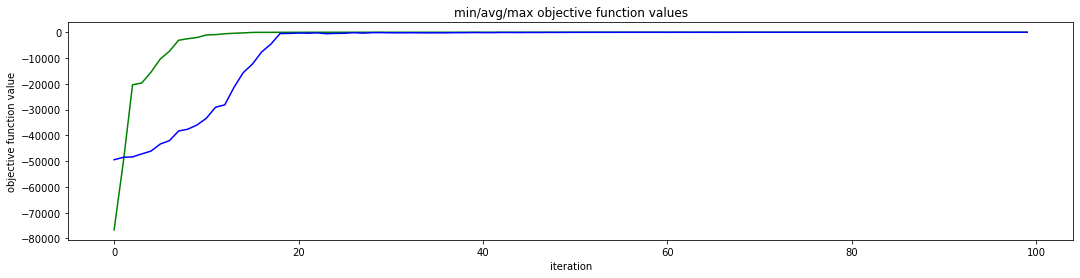

d=10
Popsize: 10
Iteration     0: 98338.51071396162


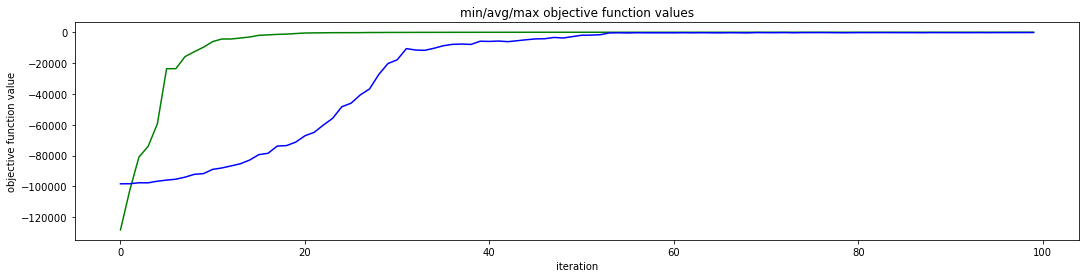

d=20
Popsize: 10
Iteration     0: 198566.78791877543


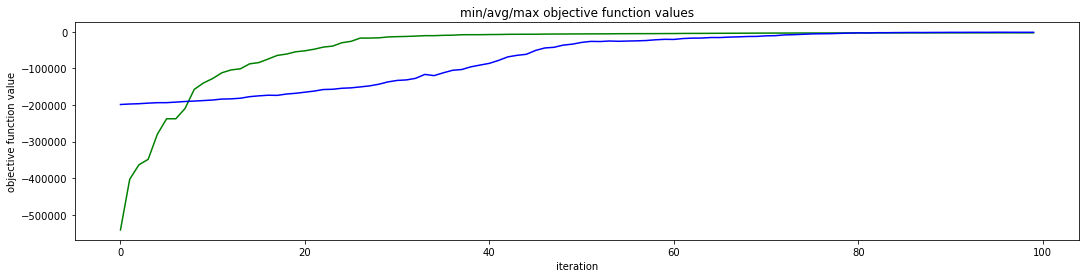

d=50
Popsize: 10
Iteration     0: 498669.22038313554


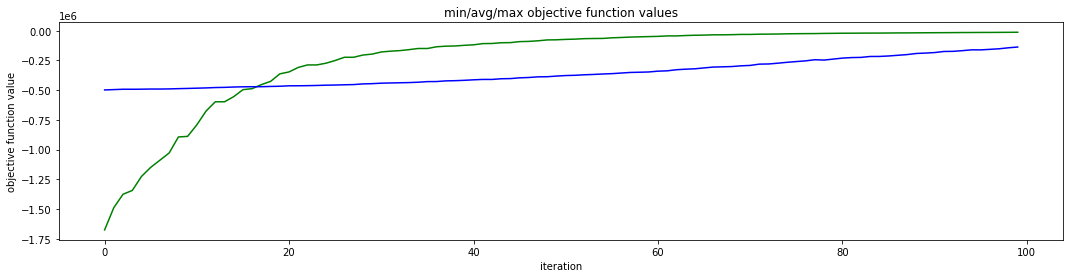

In [153]:
for d in [5,10,20,50]:
    print("d={}".format(d))
    N = 10
    T = 100

    x0 = np.repeat(100.0, d)
    res = optimize(sphere_function, x0, 1, popsize=N,generations_plot = False)
    y = np.array([nd for st, nd in res])
    T = len(y)
    best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
        objective_function_F1, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 10)

    plt.figure(figsize=(18, 4))
    plt.plot(history_objective_values[:, 1], 'g-')
    plt.plot(-y, 'b-')
    plt.xlabel('iteration')
    plt.ylabel('objective function value')
    plt.title('min/avg/max objective function values')
    plt.show()

Rastrigin function

In [154]:
def objective_function_F6(X):
    return - 10.0 * X.shape[0] - np.sum(X**2) + 10.0 * np.sum(np.cos(2 * np.pi * X))

d=5
Popsize: 10
Iteration     0: 49420.998764004275


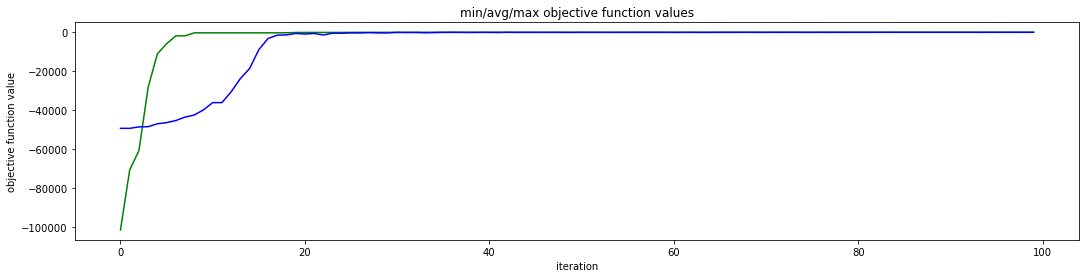

d=10
Popsize: 10
Iteration     0: 99147.5938679093


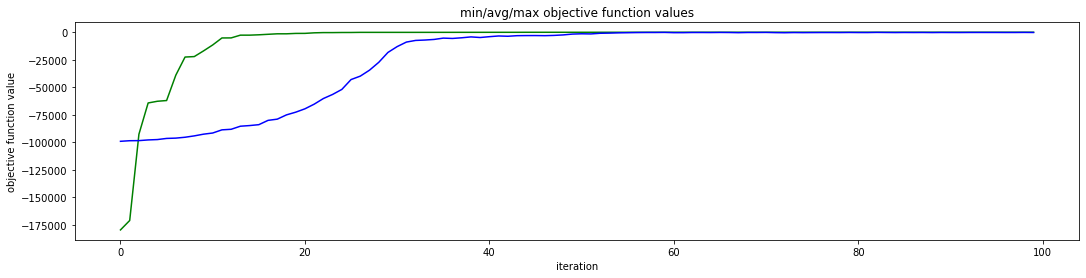

d=20
Popsize: 10
Iteration     0: 199284.92283461182


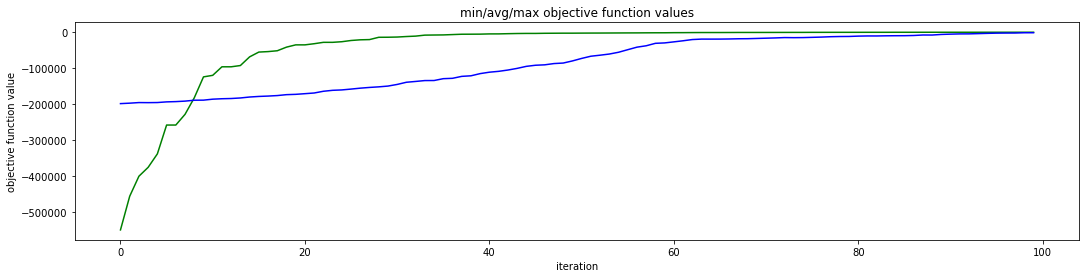

d=50
Popsize: 10
Iteration     0: 497608.7948834231


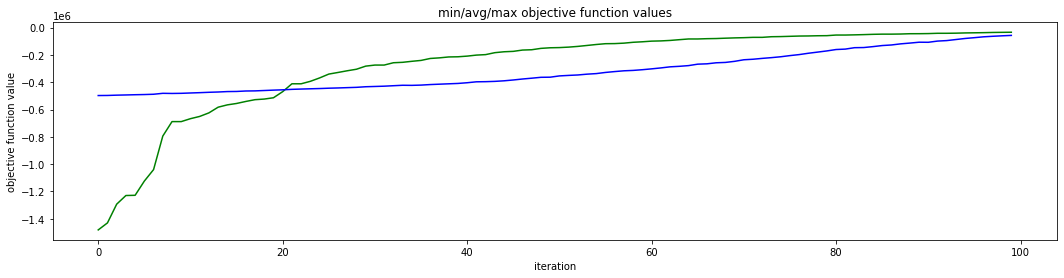

In [155]:
for d in [5,10,20,50]:
    print("d={}".format(d))
    N = 10
    T = 100

    x0 = np.repeat(100.0, d)
    res = optimize(rastrigin_function, x0, 1, popsize=N,generations_plot = False)
    y = np.array([nd for st, nd in res])
    T = len(y)
    best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
        objective_function_F6, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 10)

    plt.figure(figsize=(18, 4))
    plt.plot(history_objective_values[:, 1], 'g-')
    plt.plot(-y, 'b-')
    plt.xlabel('iteration')
    plt.ylabel('objective function value')
    plt.title('min/avg/max objective function values')
    plt.show()

Schwefel function

In [156]:
def objective_function_F7(X):
    return - 418.9829 * X.shape[0] + np.sum(X * np.sin(np.sqrt(np.abs(X))))

d=5
Popsize: 10
Iteration     0: 2345.0365098327534


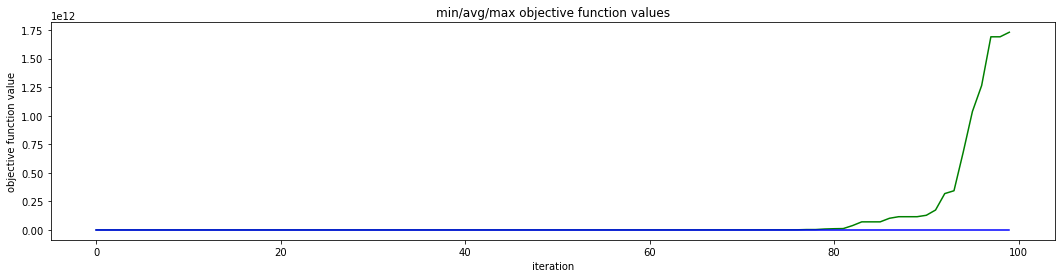

d=10
Popsize: 10
Iteration     0: 4694.771310353277


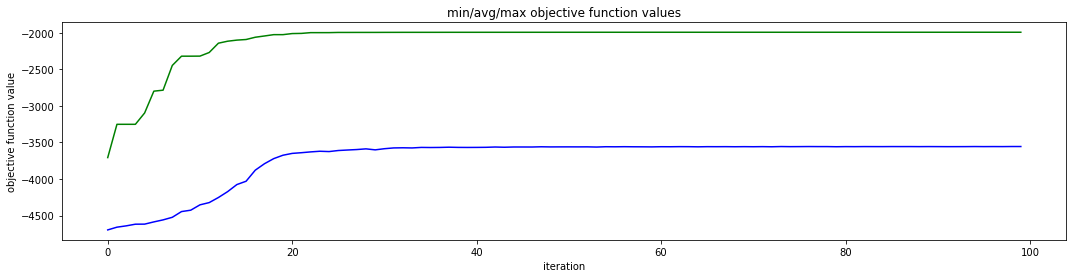

d=20
Popsize: 10
Iteration     0: 9429.72872157165


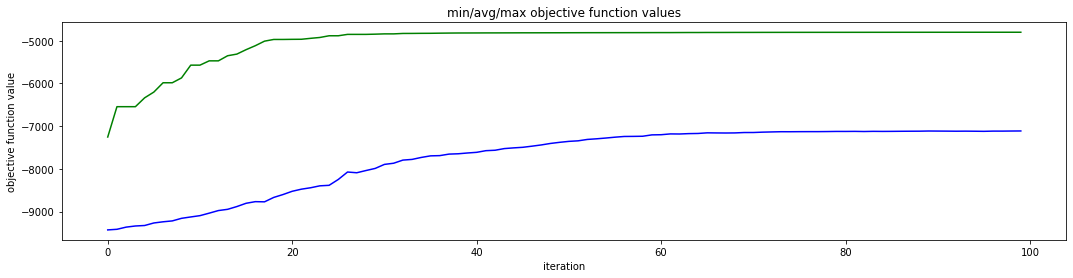

d=50
Popsize: 10
Iteration     0: 23638.819984575966


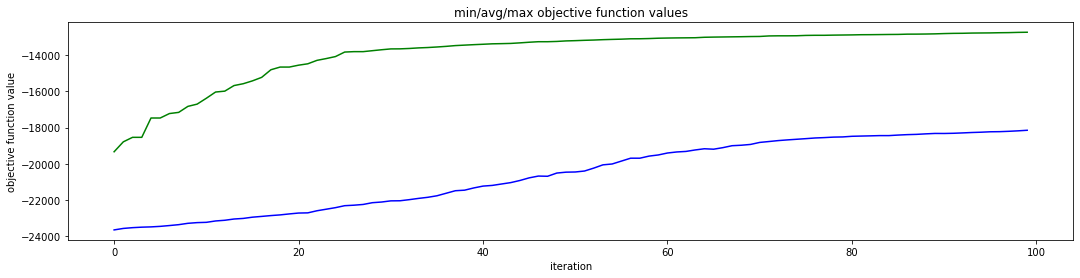

In [157]:
for d in [5,10,20,50]:
    print("d={}".format(d))
    N = 10
    T = 100

    x0 = np.repeat(100.0, d)
    res = optimize(schwefel_function, x0, 1, popsize=N,generations_plot = False)
    y = np.array([nd for st, nd in res])
    T = len(y)
    best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
        objective_function_F7, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 10)

    plt.figure(figsize=(18, 4))
    plt.plot(history_objective_values[:, 1], 'g-')
    plt.plot(-y, 'b-')
    plt.xlabel('iteration')
    plt.ylabel('objective function value')
    plt.title('min/avg/max objective function values')
    plt.show()

Griewank function

In [158]:
def objective_function_F8(X):
    return - 1 - np.sum(X**2 / 4000) + np.prod(np.cos(X / np.sqrt(np.linspace(1, X.shape[0], X.shape[0]))))

d=5
Popsize: 10
Iteration     0: 13.236887908412127


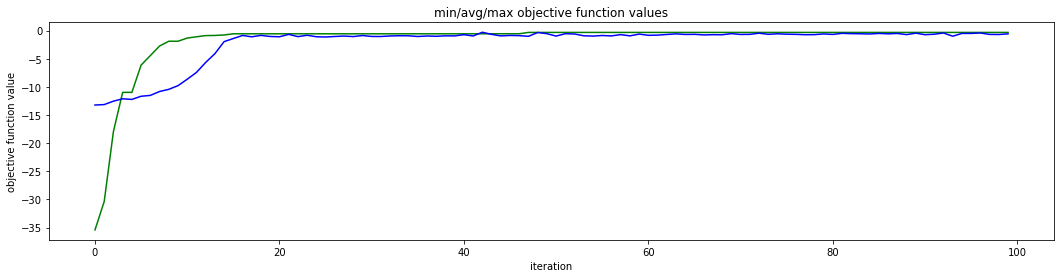

d=10
Popsize: 10
Iteration     0: 25.755003038986164


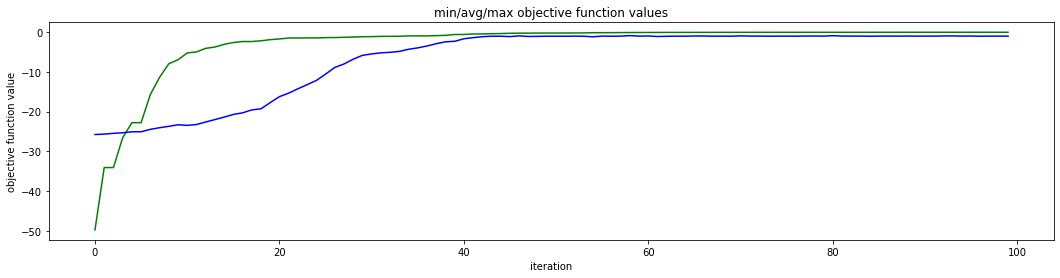

d=20
Popsize: 10
Iteration     0: 50.592979461422146


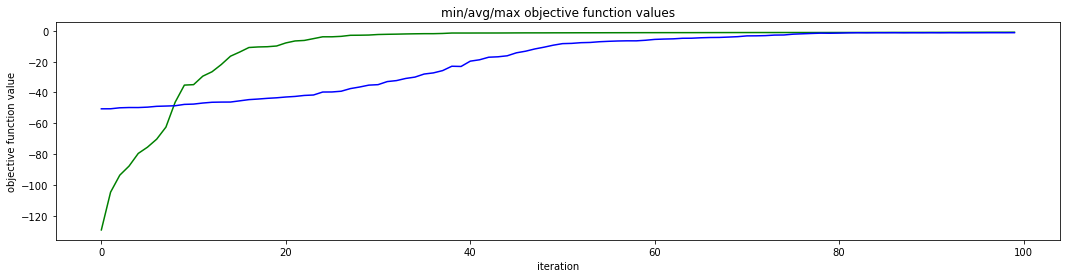

d=50
Popsize: 10
Iteration     0: 125.40866292532407


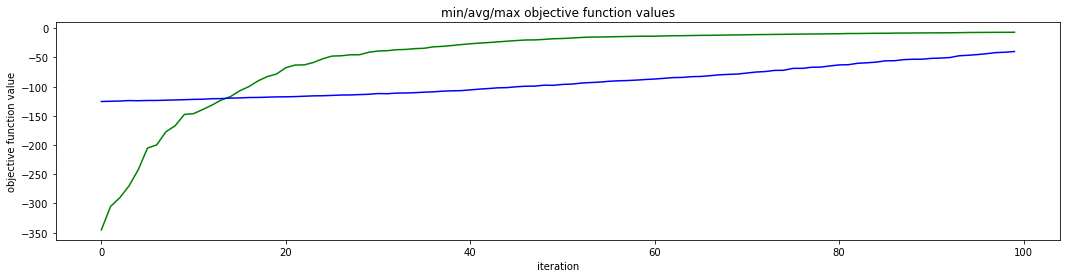

In [159]:
for d in [5,10,20,50]:
    print("d={}".format(d))
    N = 10
    T = 100

    x0 = np.repeat(100.0, d)
    res = optimize(griewank_function, x0, 1, popsize=N,generations_plot = False)
    y = np.array([nd for st, nd in res])
    T = len(y)
    best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
        objective_function_F8, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 10)

    plt.figure(figsize=(18, 4))
    plt.plot(history_objective_values[:, 1], 'g-')
    plt.plot(-y, 'b-')
    plt.xlabel('iteration')
    plt.ylabel('objective function value')
    plt.title('min/avg/max objective function values')
    plt.show()

### Zadanie 3

In [211]:
class CMA_ES2:
    def __init__(self, x0, sigma, maxfevals = 10000, popsize = None, weights = None):
        N = x0.shape[0]
        self.dimension = N
        self.chiN = N**0.5 * (1 - 1. / (4 * N) + 1. / (21 * N**2))
        self.lam = 4 + int(3 * np.log(N)) if not popsize else popsize
        print(f"Popsize: {self.lam}")
        self.mu = int(self.lam / 2)
        
        if weights:
            self.weights = weights
        else:
            self.weights = np.array([np.log(self.lam / 2 + 0.5) - np.log(i + 1) for i in range(self.lam)])
            self.weights /= np.sum(self.weights)
        self.mueff = np.sum(self.weights)**2 / np.sum(self.weights**2)
        
        self.cc = (4 + self.mueff/N) / (N+4 + 2 * self.mueff/N)
        self.cs = (self.mueff + 2) / (N + self.mueff + 5)
        self.c1 = 2 / ((N + 1.3)**2 + self.mueff) 
        self.cmu = min([1 - self.c1, 2 * (self.mueff - 2 + 1/self.mueff) / ((N + 2)**2 + self.mueff)])
        self.damps = 2 * self.mueff/self.lam + 0.3 + self.cs

        self.xmean = x0[:]
        self.sigma = sigma
        self.pc = np.zeros(N) 
        self.ps =np.zeros(N) 
        self.lazy_gap_evals = 0.5 * N * self.lam * (self.c1 + self.cmu)**-1 / N**2
        self.maxfevals = maxfevals
        self.C = np.identity(N)
        self.counteval = 0 
        self.fitvals = np.array([])  
        self.best = (x0, None)
        self.condition_number = 1
        self.eigen_values = np.ones(N)
        self.eigen_vectors = np.identity(N)
        self.updated_eval = 0
        self.inv_sqrt = np.identity(N)

    def _update_eigensystem(self, current_eval, lazy_gap_evals):
        if current_eval <= self.updated_eval + lazy_gap_evals:
            return self
        self.eigen_values, self.eigen_vectors = np.linalg.eig(self.C)
        self.inv_sqrt = self.eigen_vectors @ np.diag(self.eigen_values**-0.5) @ self.eigen_vectors.T
        self.condition_number = self.eigen_values.max() / self.eigen_values.min()
         
    def sample(self):
        """Wylosuj próbkę nowych osobników"""
        y = self.xmean + self.sigma * np.random.multivariate_normal(np.zeros(self.dimension),
                                                                    self.C,self.lam)
        return y
    
    def update(self, x, fitvals):
        """Zaktualizuj wartości uzyskanych parametrów"""
        self.counteval += fitvals.shape[0] # Zwiększamy licznik wykonań
        N = self.xmean.shape[0]
        x_old = self.xmean.copy()
        
        # Posortuj osobniki po wartości funkcji celu
        # TODD
        I = np.argsort(fitvals)
        x = x[I, :]
        self.fitvals = fitvals[I]
        self.best = (x[0], self.fitvals[0])
        self.xmean = (self.weights @ x).ravel()
        y = x - x_old
        diff = self.xmean - x_old
        z = (self.inv_sqrt @ y.T).T
        
        # Aktualizacja ścieżki ewolucji dla sigmy
        self.ps = (1-self.cs)*self.ps + np.sqrt(self.cs*(2-self.cs)*self.mueff) * (self.inv_sqrt @ diff / self.sigma )
        
        # Aktualizacja ścieżki ewolucji dla macierzy kowariancji
        self.pc = (1-self.cc)*self.pc + np.sqrt(self.cc*(2-self.cc)*self.mueff) * diff / self.sigma
        
        #Aktualizacja macierzy kowariancji
        beta = (4*self.mu -2)/((self.dimension+12)**2 + 4*self.mu)
        c_cov = 2/((self.dimension+np.sqrt(2))**2)
        weights_Z = self.weights[:self.mu] / np.sum(self.weights[:self.mu])
        tmp1 =  1/self.mu * np.sum(np.array([w * yi.reshape(-1,1) @ yi.reshape(1,-1) for w, yi in zip(weights_Z, y[:self.mu])]), axis=0)
        tmp2 =  1/self.mu * np.sum(np.array([w * yi.reshape(-1,1) @ yi.reshape(1,-1) for w, yi in zip(weights_Z[::-1], y[self.mu:])]), axis=0)
        Z = self.eigen_vectors @ np.diag(self.eigen_values**0.5) @ (tmp1-tmp2) @ (self.eigen_vectors @ np.diag(self.eigen_values**0.5)).T
        self.C = (1-c_cov)*self.C + c_cov * self.pc.reshape(-1,1) @ self.pc.reshape(1,-1) + beta*Z

        self.C = (self.C + self.C.T)/2.0 # Upewniamy się, że macierz jest symetryczna

        # Aktualizacja rozmiaru kroku
        
        self.sigma = self.sigma * np.exp(self.cmu/self.damps * (np.linalg.norm(self.ps) / self.chiN - 1))
        self._update_eigensystem(self.counteval,self.lazy_gap_evals)
        
    def terminate(self):
        """Zakończ algorytm"""
        if self.counteval <= 0:
            return False
        if self.counteval >= self.maxfevals:
            return True
        if self.condition_number > 1e13:
            return True
        if self.sigma * np.max(self.eigen_values)**0.5 < 1e-13:
            return True
        return False

In [212]:
def optimize2(func, x0, sigma, maxfevals = 1000, popsize = None, weights = None):
    cma_es = CMA_ES2(x0, sigma, maxfevals, popsize, weights)
    res = []
    cntr = -1
    while not cma_es.terminate():
        cntr+=1
        x = cma_es.sample()
        f_eval = func(x)
        cma_es.update(x, f_eval)
        res.append(cma_es.best)
        if cntr % 100 == 0:
            print(f"Iteration {cntr:5d}: {res[-1][1]}")
    return res

f:  sphere_function
d=40
Popsize: 6
Iteration     0: 399088.3207605853
Iteration   100: 137546.02858931656
Popsize: 6
Iteration     0: 398428.9420108176
Iteration   100: 24227.134218570696


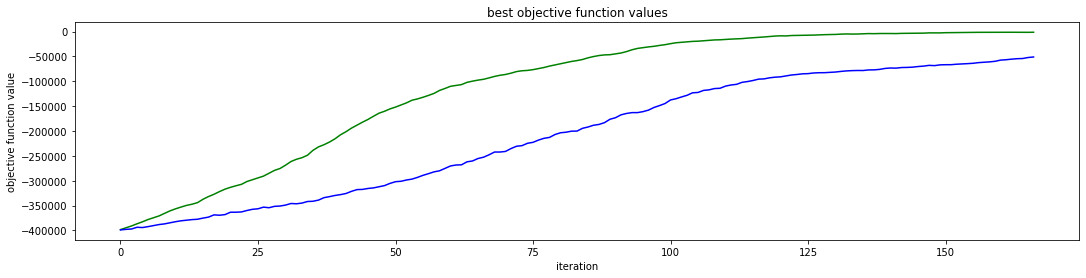

d=50
Popsize: 6
Iteration     0: 499222.68499767
Iteration   100: 252962.75354580695
Popsize: 6
Iteration     0: 498027.7605739794
Iteration   100: 53998.806414978906


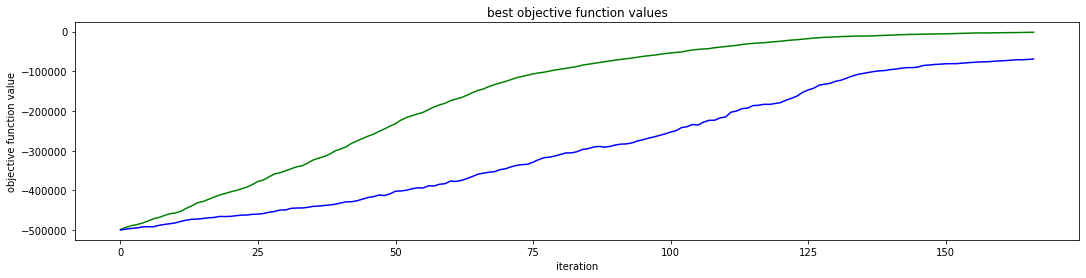

d=70
Popsize: 6
Iteration     0: 698334.5673103423
Iteration   100: 444915.025461244
Popsize: 6
Iteration     0: 695880.0348850526


<ipython-input-211-595298375385>:48: ComplexWarning:

Casting complex values to real discards the imaginary part



Iteration   100: 144372.09875057611


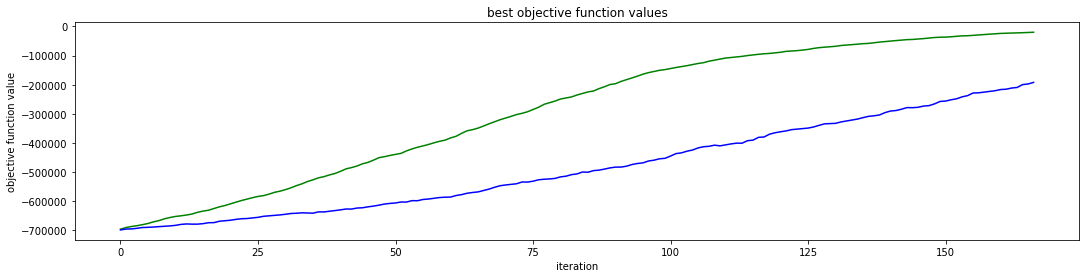

f:  rastrigin_function
d=40
Popsize: 6
Iteration     0: 398990.464853798
Iteration   100: 184262.39098790963
Popsize: 6
Iteration     0: 398537.42254111223
Iteration   100: 21312.147227626578


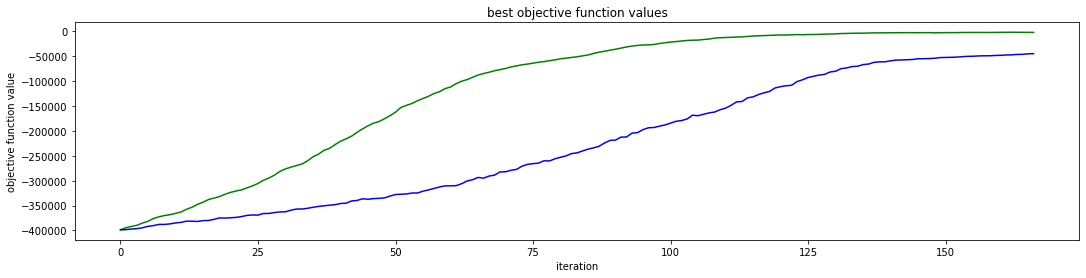

d=50
Popsize: 6
Iteration     0: 497692.9764139289
Iteration   100: 242160.28005233925
Popsize: 6
Iteration     0: 498390.8792340751
Iteration   100: 67310.5360040218


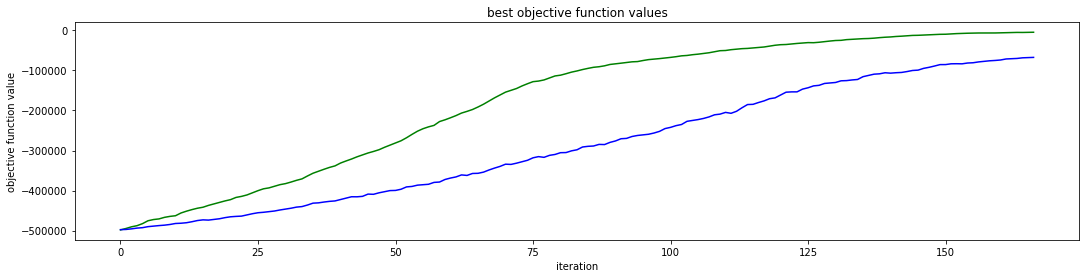

d=70
Popsize: 6
Iteration     0: 698837.353995563
Iteration   100: 452455.8264816586
Popsize: 6
Iteration     0: 698688.0814395895


<ipython-input-211-595298375385>:48: ComplexWarning:

Casting complex values to real discards the imaginary part



Iteration   100: 149136.1123757548


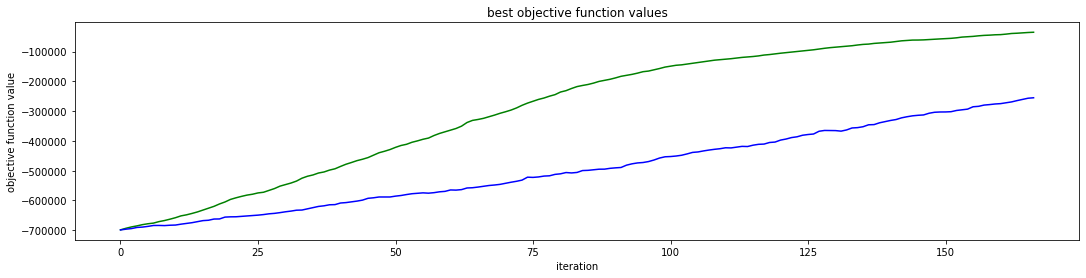

f:  ellipsoid_function
d=40
Popsize: 6
Iteration     0: 574380.3222065626
Iteration   100: 213888.84634601677
Popsize: 6
Iteration     0: 573926.7454432083
Iteration   100: 31247.3777743432


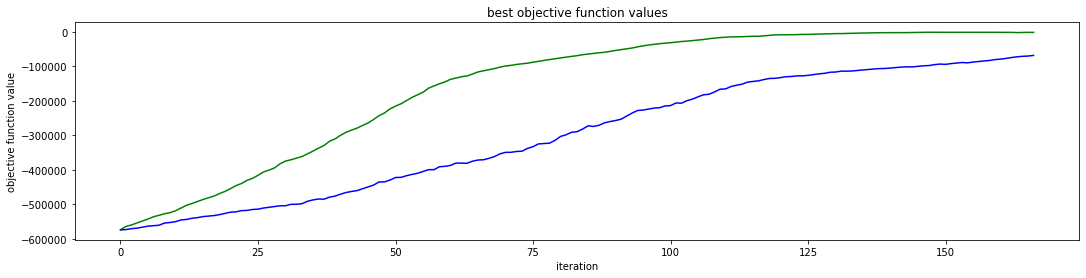

d=50
Popsize: 6
Iteration     0: 718291.2460984392
Iteration   100: 414204.44804519316
Popsize: 6
Iteration     0: 720037.8650036633
Iteration   100: 108289.00144794949


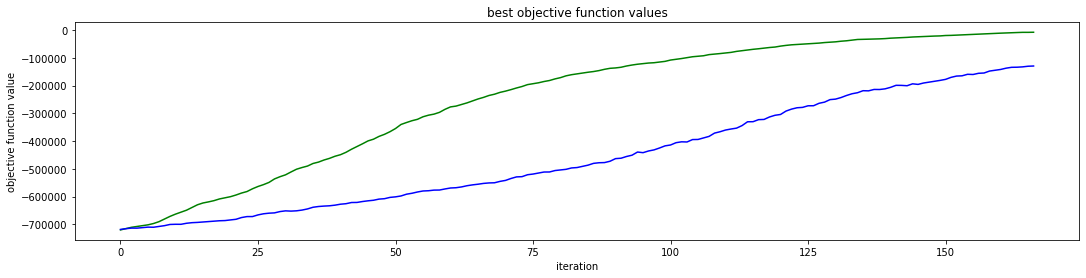

d=70
Popsize: 6
Iteration     0: 1006948.9682637223
Iteration   100: 632584.0351856621
Popsize: 6
Iteration     0: 1007855.6948804372
Iteration   100: 241725.2354234128


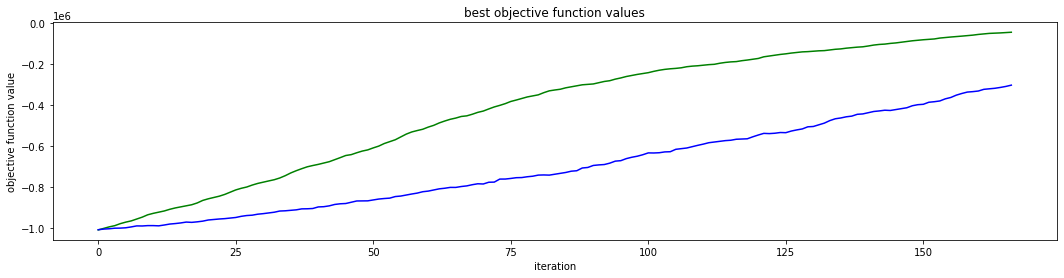

f:  schwefel_function
d=40
Popsize: 6
Iteration     0: 18893.04568712291
Iteration   100: 15325.98053388956
Popsize: 6
Iteration     0: 18848.06857812042
Iteration   100: 14283.045371344775


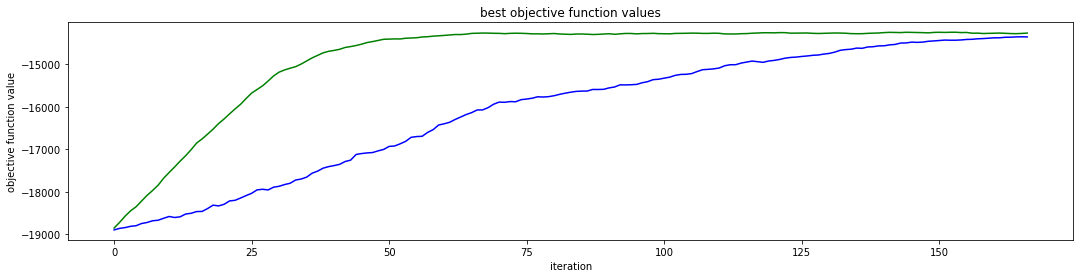

d=50
Popsize: 6
Iteration     0: 23653.06254783482
Iteration   100: 19168.536100866026
Popsize: 6
Iteration     0: 23648.877867652656
Iteration   100: 17870.370497327745


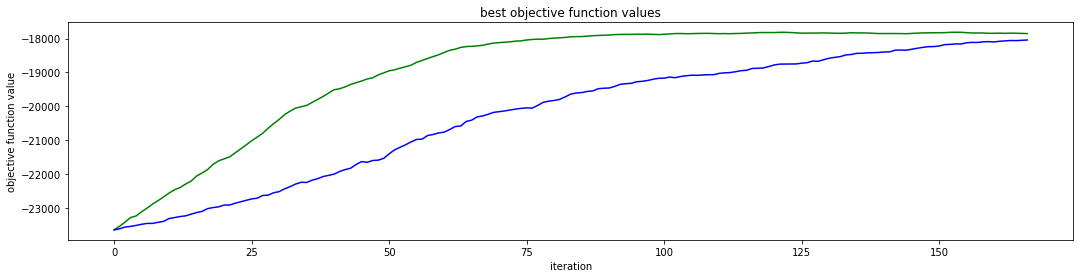

d=70
Popsize: 6
Iteration     0: 33140.01969725939
Iteration   100: 27296.21596205722
Popsize: 6
Iteration     0: 33092.309414600895


<ipython-input-211-595298375385>:48: ComplexWarning:

Casting complex values to real discards the imaginary part



Iteration   100: 25029.859718583582


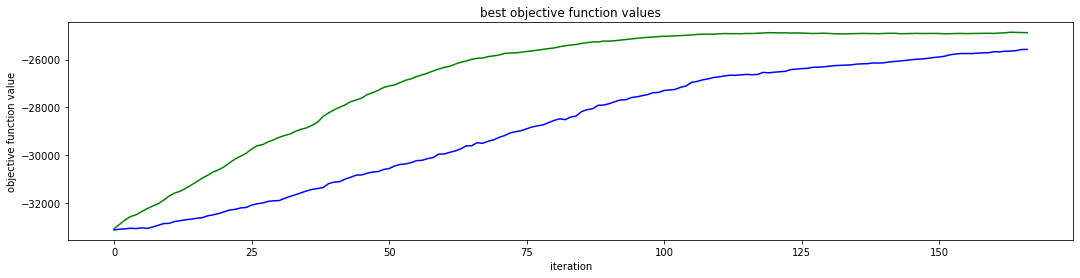

f:  griewank_function
d=40
Popsize: 6
Iteration     0: 100.31828030011226
Iteration   100: 36.274075096233005
Popsize: 6
Iteration     0: 100.69162080577786
Iteration   100: 7.948049313702126


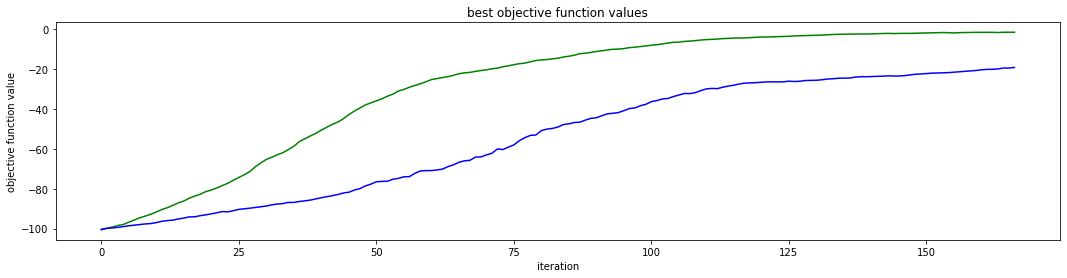

d=50
Popsize: 6
Iteration     0: 125.90863959803042
Iteration   100: 67.20952927529987
Popsize: 6
Iteration     0: 125.7218159757636


<ipython-input-211-595298375385>:48: ComplexWarning:

Casting complex values to real discards the imaginary part



Iteration   100: 16.267819996697224


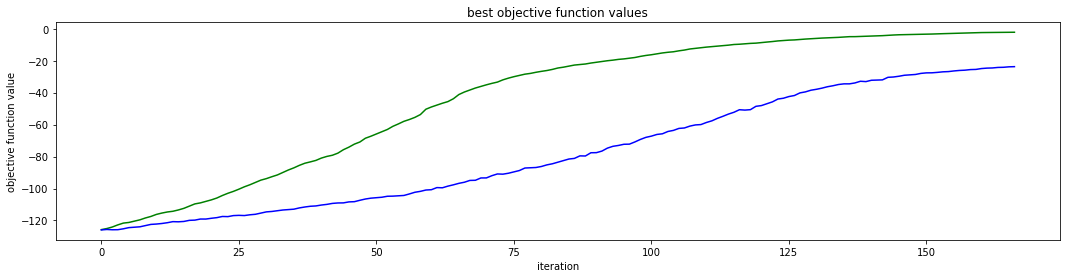

d=70
Popsize: 6
Iteration     0: 175.63415741049357
Iteration   100: 119.58973839046575
Popsize: 6
Iteration     0: 175.73596429963177
Iteration   100: 41.92555746991836


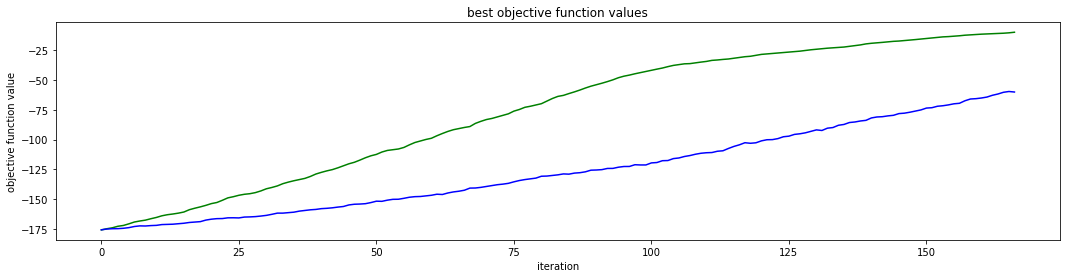

In [221]:
functions = [sphere_function, rastrigin_function, ellipsoid_function, schwefel_function, griewank_function]
functions_names = ["sphere_function", "rastrigin_function", "ellipsoid_function", "schwefel_function", "griewank_function"]

for f,f_n in zip(functions, functions_names):
    print('f: ',f_n)
    for d in [40,50,70]:
        print("d={}".format(d))
        N = 6
        T = 100

        x0 = np.repeat(100.0, d)
        res = optimize(f, x0, 1, popsize=N,generations_plot = False)
        y = np.array([nd for st, nd in res])
        x02 = np.repeat(100.0, d)
        
        res2 = optimize2(f, x0, 1, popsize=N)
        y2 = np.array([nd for st, nd in res2])

        plt.figure(figsize=(18, 4))
        plt.plot(-y2, 'g-')
        plt.plot(-y, 'b-')
        plt.xlabel('iteration')
        plt.ylabel('objective function value')
        plt.title('best objective function values')
        plt.show()